# Question 3: Investigating Topology in Node-Based Classification Using GNNs

In this section, we will explore the impact of graph topology on node-based classification using GNNs. The experiments will focus on analyzing different topological measures, visualizing their distributions, and evaluating GCN performance on 2 graphs with different topologies.

In [2]:
import json
import torch
import os
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from graph_ricci_curvature import GraphRicciCurvature

## Helper function and code for loading data

In [3]:
G1_TRAIN_FILE_NAME = "q3_G1_train.json"
G1_EVAL_FILE_NAME = "q3_G1_eval.json"

G1_TRAIN_DATA_PATH = os.path.join("data",G1_TRAIN_FILE_NAME)
G1_EVAL_DATA_PATH = os.path.join("data",G1_EVAL_FILE_NAME)

G2_TRAIN_FILE_NAME = "q3_G2_train.json"
G2_EVAL_FILE_NAME = "q3_G2_eval.json"

G2_TRAIN_DATA_PATH = os.path.join("data",G2_TRAIN_FILE_NAME)
G2_EVAL_DATA_PATH = os.path.join("data",G2_EVAL_FILE_NAME)

In [4]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    if not type(data) == list:
        item = data
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        return (X,A,y)

    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 3.1 - Analyzing the Graphs


### Q3.1.b Visualizing and Comparing Topological and Geometric Measures of Two Graphs

Implement the following three functions to visualize and compare structural properties of two given graphs:

- `plot_node_degree_distribution_two_graphs`
- `plot_betweenness_centrality_distribution_two_graphs`
- `plot_ollivier_ricci_curvature_distribution_two_graphs`




In [5]:
def compute_node_degree(A):
    """
    Given an adjacency matrix A of shape (N, N),
    return the degree (row sum) for each of the N nodes.
    """
    degrees = A.sum(dim=1)  # sum across columns
    return degrees

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


def plot_node_degree_distribution_two_graphs(A1, A2, label1='Graph 1', label2='Graph 2'):
    """
    Plots the node degree distributions of two graphs
    with adjacency matrices A1 and A2 (each of shape (N, N))
    in a single figure.
    
    """
    degrees_1 = compute_node_degree(A1).cpu().numpy()
    degrees_2 = compute_node_degree(A2).cpu().numpy()

    # Plot degree distributions
    plt.figure(figsize=(10, 6))
    plt.hist(degrees_1, bins=range(int(degrees_1.max()) + 2), alpha=0.6, label=label1, color='skyblue', edgecolor='black', density=True)
    plt.hist(degrees_2, bins=range(int(degrees_2.max()) + 2), alpha=0.6, label=label2, color='salmon', edgecolor='black', density=True)

    plt.title("Node Degree Distribution of Two Graphs")
    plt.xlabel("Node Degree")
    plt.ylabel("Frequency (Normalised)")
    plt.legend(loc="upper right")
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


In [6]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
def compute_betweenness_centrality(A):
    """
    Computes the betweenness centrality for each node in a graph
    given its adjacency matrix A.
    
    Args:
        A (torch.Tensor): Adjacency matrix of shape (N, N).
    
    Returns:
        torch.Tensor: Betweenness centrality values for each node (N,).
    """
    # Convert adjacency matrix to NetworkX graph
    G = nx.from_numpy_array(A.cpu().numpy())
    centrality_dict = nx.betweenness_centrality(G, normalized=True)
    
    # Convert dict to tensor
    centrality_values = torch.tensor(list(centrality_dict.values()), dtype=torch.float)
    return centrality_values


def plot_betweenness_distribution_two_graphs(A1, A2, label1="Graph 1", label2="Graph 2"):
    """
    Plots the betweenness centrality distributions of two graphs
    defined by adjacency matrices A1 and A2 in a single figure.
    
    Args:
        A1 (torch.Tensor): Adjacency matrix of the first graph (N, N).
        A2 (torch.Tensor): Adjacency matrix of the second graph (N, N).
        label1 (str): Label for the first graph in the plot legend.
        label2 (str): Label for the second graph in the plot legend.
    """
    # Compute betweenness centrality for both graphs
    bc_1 = compute_betweenness_centrality(A1).cpu().numpy()
    bc_2 = compute_betweenness_centrality(A2).cpu().numpy()

    # Plot betweenness centrality distributions
    plt.figure(figsize=(10, 6))
    plt.hist(bc_1, bins=30, alpha=0.6, label=label1, color='skyblue', edgecolor='black', density=True)
    plt.hist(bc_2, bins=30, alpha=0.6, label=label2, color='salmon', edgecolor='black', density=True)

    plt.title("Betweenness Centrality Distribution of Two Graphs")
    plt.xlabel("Betweenness Centrality")
    plt.ylabel("Frequency (Normalised)")
    plt.legend(loc="upper right")
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


In [7]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def plot_ricci_curvature_distribution_two_graphs(A1, A2, label1="Graph 1", label2="Graph 2", bins=30):
    """
    Plots the Ollivier-Ricci curvature distributions for two graphs
    defined by adjacency matrices A1 and A2 (PyTorch tensors).
    
    Parameters
    ----------
    A1, A2 : torch.Tensor
        Adjacency matrices for two undirected graphs (NxN).
    """
    # 1) Convert PyTorch adjacency -> NumPy -> NetworkX Graph
    A1_np = A1.numpy()
    A2_np = A2.numpy()

    G1 = nx.from_numpy_array(A1_np)
    G2 = nx.from_numpy_array(A2_np)

    # 2) Instantiate OllivierRicci object for each graph
    ricci_calculator_G1 = GraphRicciCurvature(G1)
    ricci_calculator_G2 = GraphRicciCurvature(G2)

    # 3) Compute the Ricci curvature
    curvatures1 = ricci_calculator_G1.compute_ricci_curvatures()
    curvatures2 = ricci_calculator_G2.compute_ricci_curvatures()

    # After computation, the Ricci curvature for each edge is stored in G[u][v]["ricciCurvature"]

    # 4) Gather edge-level Ricci curvature values
    ricci_values_G1 = []
    for (u, v), val in curvatures1.items():
        ricci_values_G1.append(val)

    ricci_values_G2 = []
    for (u, v), val in curvatures2.items():
        ricci_values_G2.append(val)

    # Continue with plotting ...
    plt.figure(figsize=(10, 6))
    plt.hist(ricci_values_G1, bins=bins, alpha=0.6, label=label1, edgecolor='black', color="skyblue", density=True)
    plt.hist(ricci_values_G2, bins=bins, alpha=0.6, label=label2, edgecolor='black', color="salmon", density=True)
    plt.xlabel("Ollivier-Ricci Curvature")
    plt.ylabel("Density")
    plt.title("Distribution of Ollivier-Ricci Curvature for Two Graphs")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [8]:
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

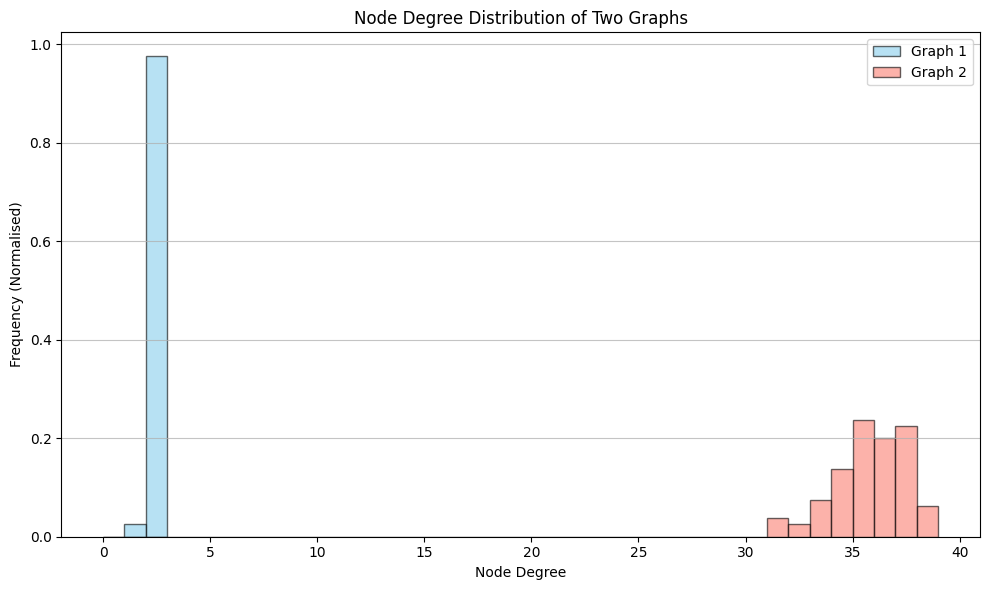

In [9]:
plot_node_degree_distribution_two_graphs(G1_train[1], G2_train[1])

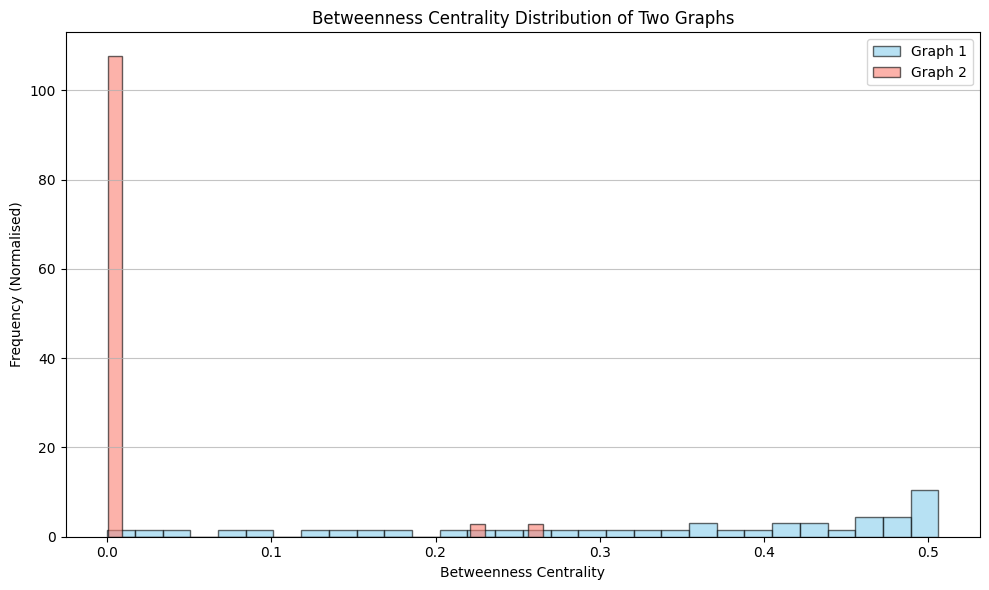

In [10]:
plot_betweenness_distribution_two_graphs(G1_train[1], G2_train[1])

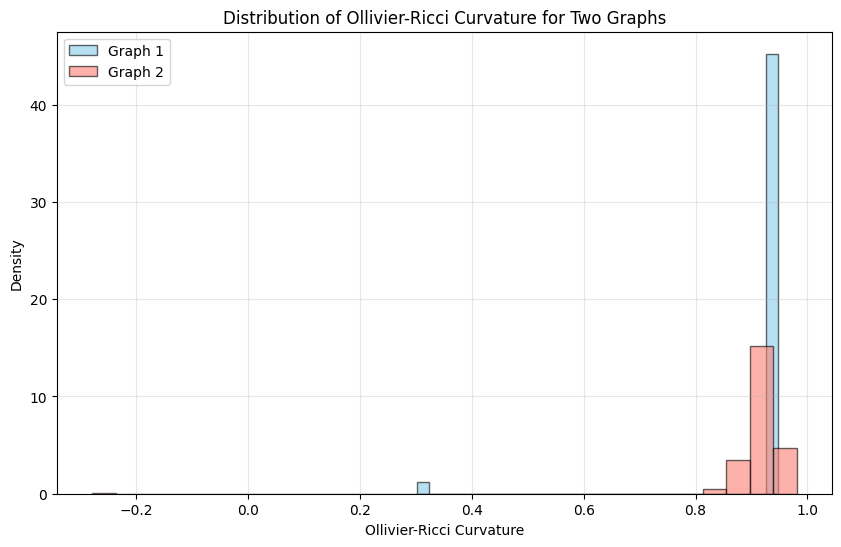

In [11]:
plot_ricci_curvature_distribution_two_graphs(G1_train[1], G2_train[1])

### Q3.1.c Visualizing the Graphs

Implement the `plot_graph` function to generate visual representations of both graphs. Ensure that the plots are clear and well-formatted.


In [12]:
def plot_graph(A, title="Graph Visualization", node_size=300, node_color='skyblue', with_labels=True):
    """
    Plots a graph defined by adjacency matrix A.
    
    Parameters
    ----------
    A : torch.Tensor
        Adjacency matrix of shape (N, N).
    title : str, optional
        Title of the graph plot. Default is "Graph Visualization".
    node_size : int, optional
        Size of the nodes in the plot. Default is 300.
    node_color : str, optional
        Color of the nodes. Default is 'skyblue'.
    with_labels : bool, optional
        Whether to show node labels. Default is True.
    """
    # Convert adjacency matrix to numpy array and create networkx graph
    A_np = A.cpu().numpy() if isinstance(A, torch.Tensor) else A
    G = nx.from_numpy_array(A_np)

    pos = nx.spring_layout(G, seed=42)

    # Plot the graph
    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos,
        with_labels=with_labels,
        node_size=node_size,
        node_color=node_color,
        edge_color='gray',
        linewidths=0.5,
        font_size=10
    )
    plt.title(title)
    plt.show()


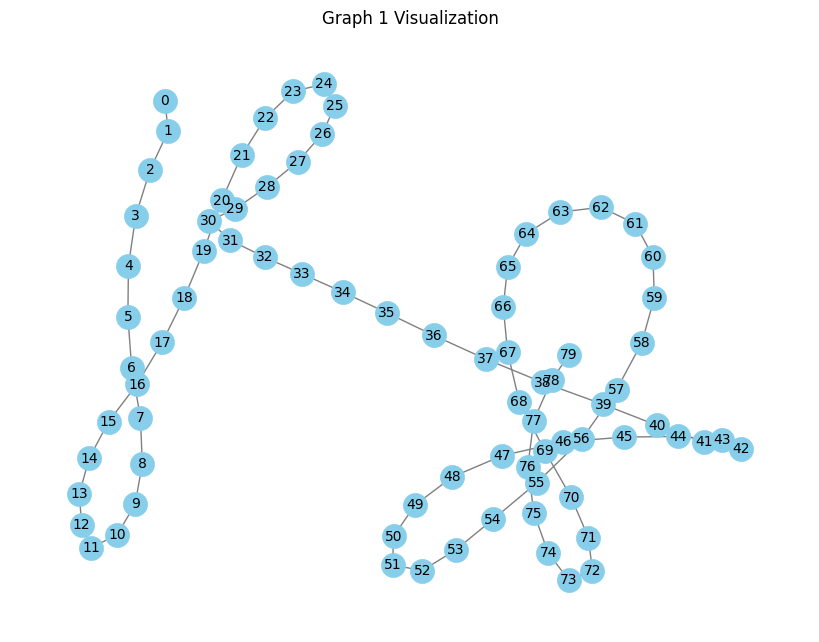

In [13]:
plot_graph(G1_train[1], title="Graph 1 Visualization")

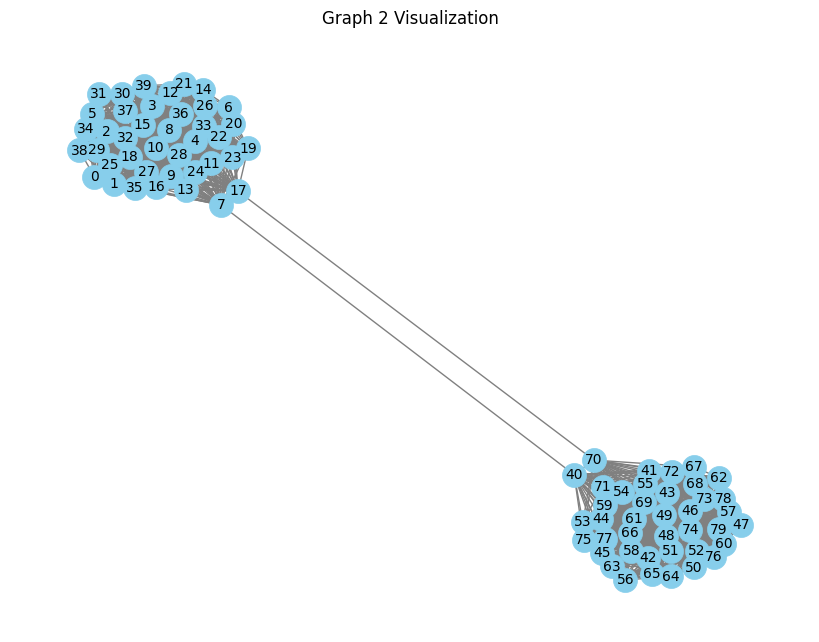

In [14]:
plot_graph(G2_train[1], title="Graph 2 Visualization")

### Q3.1.d Visualizing Node Feature Distributions

- Implement the function `plot_node_feature_dist_by_class_two_graphs` to visualize the average node feature distribution per class for two given graphs.

- Do not consider the distribution of a specific feature $ x_i $, consider the mean of the feature vector $ \mathbf{x} $ for each node.

- The function should generate a plot similar to Figure 3 in the Coursework Desciription PDF.


In [15]:
import matplotlib.pyplot as plt
import torch

def plot_node_feature_dist_by_class_two_graphs(X1, y1, X2, y2):
    """
    Plots the distribution of the average node features by class for two graphs.

    Parameters
    ----------
    X1, X2 : torch.Tensor
        Feature matrices of the two graphs (N, d).
    y1, y2 : torch.Tensor
        Corresponding class labels for the nodes in the two graphs (N,).
    """

    # Compute average feature value per node
    avg_features_graph1 = X1.mean(dim=1).numpy()
    avg_features_graph2 = X2.mean(dim=1).numpy()

    # Convert labels to numpy
    y1 = y1.numpy()
    y2 = y2.numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Graph 1
    axes[0].hist(
        avg_features_graph1[y1 == 0], bins=15, alpha=0.6, label="Class 0", color="skyblue"
    )
    axes[0].hist(
        avg_features_graph1[y1 == 1], bins=15, alpha=0.6, label="Class 1", color="sandybrown"
    )
    axes[0].set_title("Graph 1: Avg Feature Distribution by Class")
    axes[0].set_xlabel("Average Feature Value")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()

    # Graph 2
    axes[1].hist(
        avg_features_graph2[y2 == 0], bins=15, alpha=0.6, label="Class 0", color="skyblue"
    )
    axes[1].hist(
        avg_features_graph2[y2 == 1], bins=15, alpha=0.6, label="Class 1", color="sandybrown"
    )
    axes[1].set_title("Graph 2: Avg Feature Distribution by Class")
    axes[1].set_xlabel("Average Feature Value")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

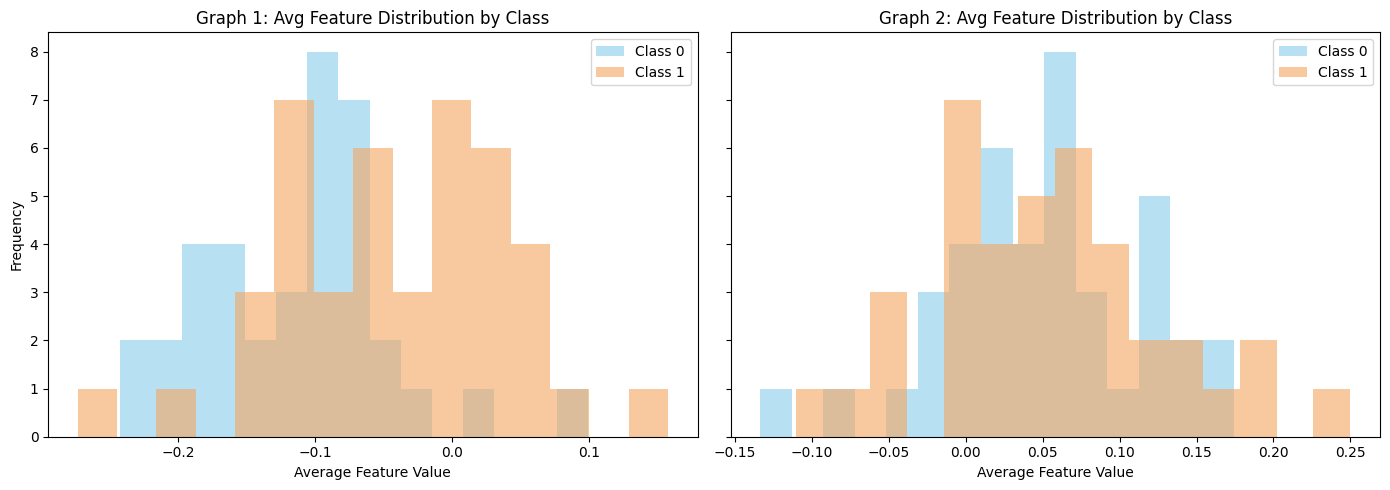

In [16]:
plot_node_feature_dist_by_class_two_graphs(G1_train[0], G1_train[2], G2_train[0], G2_train[2])

## Question 3.2 -  Evaluating GCN Performance on Different Graph Structures


### Helper functions for normalising the A matrix.

In [17]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


def patch_A_matrix(A):
    """Patches the A matrix"""
    A = A + torch.eye(A.size(0))
    A = symmetric_normalize(A)
    return A

def patch_A_for_dataset(dataset):
    """Patches the A matrix for a dataset (list)"""
    dataset = [ (X, patch_A_matrix(A), y) for X,A,y in dataset]
    return dataset

### Helper function for plotting training runs.

In [18]:
def plot_training_and_validation(graph1_vals, graph2_vals=None, aggregation="mean", graph1_label="Training Accuracy", graph2_label="Validation Accuracy", x_label="Epoch",title="Training Accuracy and Validation Accuracy Over Time"):
    """
    Plots the validation accuracy and training loss over epochs.
    Has been modified to plot either 1 or two axes, and any two labels for the graphs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    if graph2_vals:
        ax2 = ax1.twinx()
    
    # Plot training loss on the first y-axis. Modified to plot graph1_vals on the first y-axis
    epochs = range(1, len(graph1_vals) + 1)
    line1 = ax1.plot(epochs, graph1_vals, 'r-', label=f'{graph1_label}')
    ax1.set_xlabel(f"{x_label}")
    ax1.set_ylabel(f'{graph1_label}', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    # Plot validation accuracy on the second y-axis. Modified to optionally plot graph2_vals on the second y-axis
    if graph2_vals:
        line2 = ax2.plot(epochs, graph2_vals, 'b-', label=f'{graph2_label}')
        ax2.set_ylabel(f'{graph2_label}', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
    
    # Add title and grid
    graph_title = f'{title}\nAggregation: {aggregation}'
    plt.title(graph_title)

    ax1.grid(True)
    
    # Add legend
    if graph2_vals:
        lines = line1 + line2
    else:
        lines = line1
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

### Provided GCN Code

In [19]:
#Provided GCN Implementation
class GCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(GCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class GraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(GraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = GCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = GCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, **kwargs):
        # Pass through GCN layers
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)  # Output shape: (num_nodes, 1)

        output = torch.sigmoid(H2)  # Sigmoid activation per node
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, (H1, H2)
        else:
            return output

### Helper functions for training GCN on a graph

In [20]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support

def train_model(
    model,
    G_train,
    G_val,
    num_epochs=10,
    lr=0.0001,
    verbose=True,
    **kwargs,
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the 
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    G_train  = (X_train,A_train,y_train) : input
        the Graph 1
    Y_train = (X_val,A_val,y_val)
        the Graph 2
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    verbose: bool
        whether to display the loss, f1 and val_f1


    Returns:
    --------
    loss_history : list
        The training loss history across epochs.
    f1_train_history : list
        train F1s during training
    f1_val_history : list
        val F1s during training
    """
    X_train, A_train, y_train = G_train
    X_val, A_val, y_val = G_val

    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_history = []
    train_f1_history = []
    validation_f1_history = []

    for epoch in range(num_epochs):
        # A single Epoch training.
        # TRAINING
        model.train()
        optimizer.zero_grad()
        if kwargs.get("return_embeddings", None):
            out, embeddings= model(A_train, X_train, **kwargs)
        else:
            out = model(A_train, X_train, **kwargs)
        out = out.squeeze(-1)  # shape: (N,) if needed
        y_float = y_train.float()  # for BCE

        # Compute training loss
        loss = binary_cross_entropy(out, y_float)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Record training loss
        loss_value = loss.item()
        
        # EVALUATION
        loss_history.append(loss_value)
        train_prec, train_rec, train_f1, _ = evaluate_model(model, X_train, A_train, y_train)
        val_prec, val_rec, val_f1, _ = evaluate_model(model,  X_val, A_val, y_val)

        train_f1_history.append(train_f1)
        validation_f1_history.append(val_f1)                     
        # Evaluating the model
        if verbose:
            print(f"Epoch {epoch+1}, Training Loss: {loss_value}, Train F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}")
            
    if kwargs.get("return_embeddings", None):
        return loss_history, train_f1_history, validation_f1_history, embeddings
    else:
        return loss_history, train_f1_history, validation_f1_history


@torch.no_grad()
def evaluate_model(model, X,A,y, **kwargs):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """
    model.eval()
    if kwargs.get("return_embeddings", None):
        out,_ = model(A,X,**kwargs)  # shape: (N, 1)
    else:
        out = model(A,X,**kwargs)  # shape: (N, 1)
    out = out.squeeze(-1)  # shape: (N,)
    preds = (out >= 0.5).long()

    y_true = y.cpu().numpy()
    y_pred = preds.cpu().numpy()

    return precision_recall_fscore_support(y_true, y_pred, average="micro")


### Q3.2.a - Implementation of Layered GCN


• Implement a GCN where layers can be passed as input parameter and that can return all
embedding layers. (If you will not be able to do so, to get results implement one class per
layer).

• Train the GCN on G1 and G2 independently. Plot your results. (Note: you don’t need to
get a high performance at this stage, just make sure it trains).

In [21]:
# SOLUTION Q3.2.a
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


class LayeredGCN(nn.Module):
    """
    GCN with a configurable number of layers. Returns all intermediate embeddings.
    """
    def __init__(self, input_dim, hidden_dim, num_layers):
        """
        Parameters
        ----------
        input_dim : int
            Dimension of input features.
        hidden_dims : list of int
            List specifying the output dimension of each GCN layer.
            Example: [32, 16, 8] -> 3 layers with respective hidden dims.
        """
        super(LayeredGCN, self).__init__()

        assert(num_layers >= 2, "Need at least 2 layers")  # At least 2 layers

        self.gcn_layers = nn.ModuleList()

        # First gcn layer
        self.gcn_layers.append(GCNLayer(input_dim, hidden_dim, True))

        # Middle hidden gcn layers
        for layer in range(num_layers - 1):
            self.gcn_layers.append(GCNLayer(hidden_dim, hidden_dim, True))

        self.classifier = nn.Linear(hidden_dim, 1)

        
        # self.gcn_layers.append(GCNLayer(hidden_dim, 1, False))   # Output shape: (num_nodes, output_dim)



    def forward(self, A, X, **kwargs):
        """
        Parameters
        ----------
        A : torch.Tensor
            Normalized adjacency matrix.
        X : torch.Tensor
            Feature matrix.

        Returns
        -------
        output : torch.Tensor
            Final sigmoid output per node.
        embeddings : list of torch.Tensor
            Embeddings from each GCN layer.
        """
        embeddings = []
        H = X
        for gcn in self.gcn_layers:
            H = gcn(H, A)
            embeddings.append(H)
        
        # output = torch.sigmoid(H)

        logits = self.classifier(H)
        output = torch.sigmoid(logits)

        # Handle NaNs if they appear
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, embeddings
        else:
            return output

    

# ####################################################
# END OF MODIFICATION
# ####################################################  

<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_2998399/232668213.py:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(num_layers >= 2, "Need at least 2 layers")  # At least 2 layers


### Code to run the training and evaluation of the model with different number of layers.

Adapt it as needed.

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.7888954877853394, Train F1: 0.4625, Validation F1: 0.5000
Epoch 2, Training Loss: 0.7815457582473755, Train F1: 0.4625, Validation F1: 0.5000
Epoch 3, Training Loss: 0.7742778658866882, Train F1: 0.4625, Validation F1: 0.5000
Epoch 4, Training Loss: 0.7672027349472046, Train F1: 0.4625, Validation F1: 0.5000
Epoch 5, Training Loss: 0.7602626085281372, Train F1: 0.4625, Validation F1: 0.5000
Epoch 6, Training Loss: 0.7534000873565674, Train F1: 0.4625, Validation F1: 0.5000
Epoch 7, Training Loss: 0.7467615008354187, Train F1: 0.4625, Validation F1: 0.5000
Epoch 8, Training Loss: 0.7404012680053711, Train F1: 0.4625, Validation F1: 0.5000
Epoch 9, Training Loss: 0.7344146370887756, Train F1: 0.4625, Validation F1: 0.5000
Epoch 10, Training Loss: 0.7288415431976318, Train F1: 0.4625, Validation F1: 0.5000
Epoch 11, Training Los

<Figure size 1000x600 with 0 Axes>

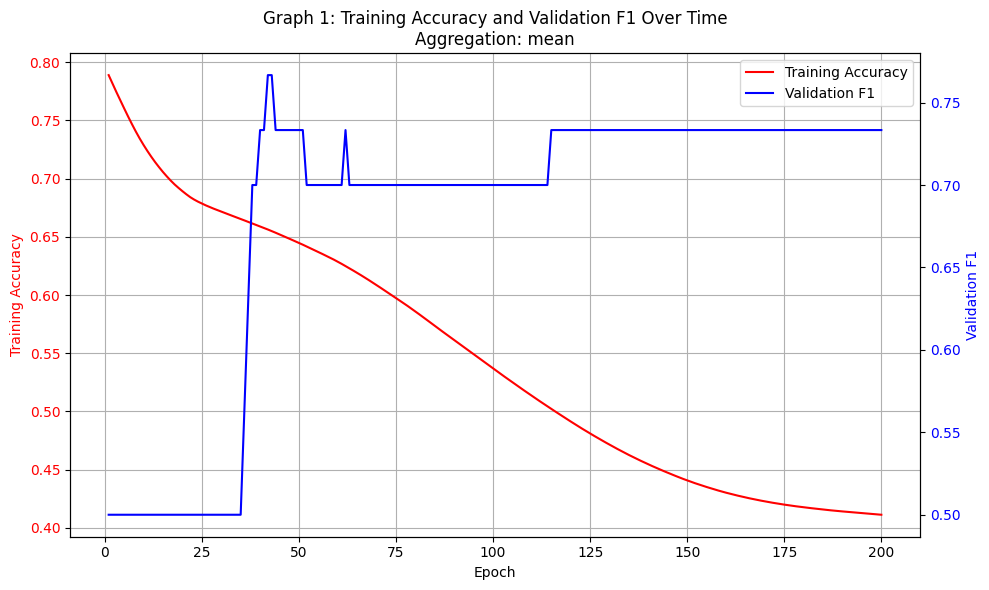

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 2, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 3, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 4, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 5, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 6, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 7, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 8, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 9, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 10, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 11, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 12, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 13

<Figure size 1000x600 with 0 Axes>

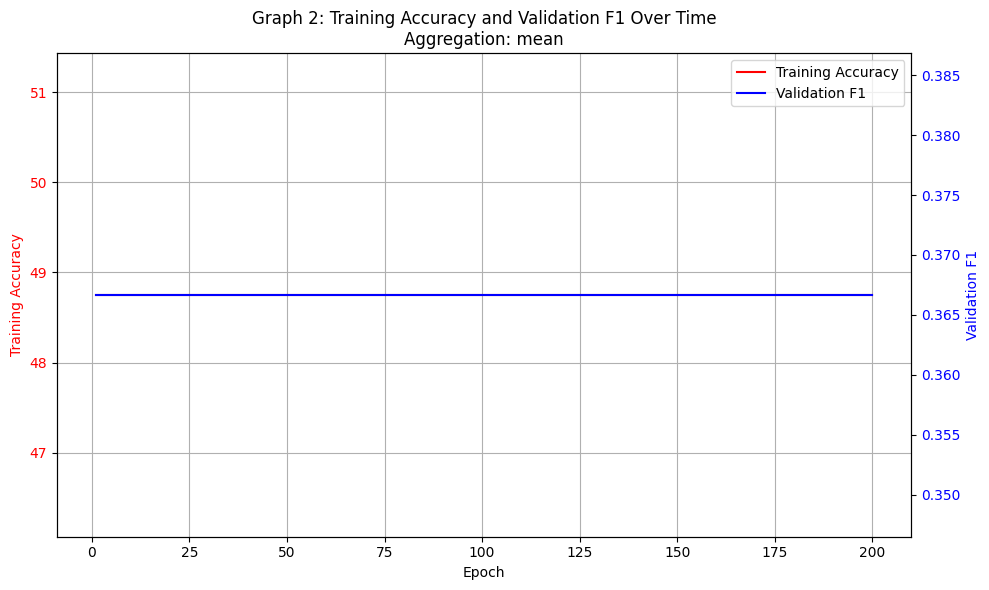

In [32]:

# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
num_layers = 4
model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)
print(model)


losses, train_f1, val_f1 = train_model(
    model,
    G1_train,
    G1_eval,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
)
plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 1: Training Accuracy and Validation F1 Over Time")


model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)
print(model)

losses, train_f1, val_f1 = train_model(
    model,
    G2_train,
    G2_eval,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 2: Training Accuracy and Validation F1 Over Time")

### Q3.2.b - Plotting of t-SNE Embeddings for Graph Neural Networks

• Use t-SNE to visualize the node embeddings for the final layer of the GCN for each graph
for both training and evaluation data, use the labels as class labels for the tsne plot.

In [41]:
# SOLUTION Q3.5.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels=None, layer_to_plot=-1, graph_name=""):
    """
    embeddings (list):
        list of embeddings (layer 2, ..., layer N)
        NOTE: for num_layer = 1 there is no embedding (as it is just the input)
    
    labels (list):
        list of labels
    
    layer_to_plot (int):
        which layer to plot (default -1, i.e. the last layer)
    """
    # Ensure embeddings are in numpy format
    selected_embeddings = embeddings[layer_to_plot].detach().cpu().numpy()
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    if labels is not None:
        labels = labels.cpu().numpy() if isinstance(labels, torch.Tensor) else labels
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Classes")
    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

    plt.title(f"{graph_name}, t-SNE Visualization of Layer {layer_to_plot if layer_to_plot >= 0 else 'Last'} Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Plotting the t-SNE embeddings

Adapt as needed.

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.6914067268371582, Train F1: 0.5375, Validation F1: 0.5000
Epoch 2, Training Loss: 0.687557578086853, Train F1: 0.5375, Validation F1: 0.5000
Epoch 3, Training Loss: 0.6837456822395325, Train F1: 0.5375, Validation F1: 0.5000
Epoch 4, Training Loss: 0.680019199848175, Train F1: 0.5375, Validation F1: 0.5000
Epoch 5, Training Loss: 0.6764113306999207, Train F1: 0.5375, Validation F1: 0.5000
Epoch 6, Training Loss: 0.6728967428207397, Train F1: 0.5375, Validation F1: 0.5000
Epoch 7, Training Loss: 0.6695042848587036, Train F1: 0.5375, Validation F1: 0.5000
Epoch 8, Training Loss: 0.6660975217819214, Train F1: 0.5375, Validation F1: 0.5000
Epoch 9, Training Loss: 0.6627417802810669, Train F1: 0.5375, Validation F1: 0.5000
Epoch 10, Training Loss: 0.6593983173370361, Train F1: 0.5375, Validation F1: 0.5000
Epoch 11, Training Loss:

<Figure size 1000x600 with 0 Axes>

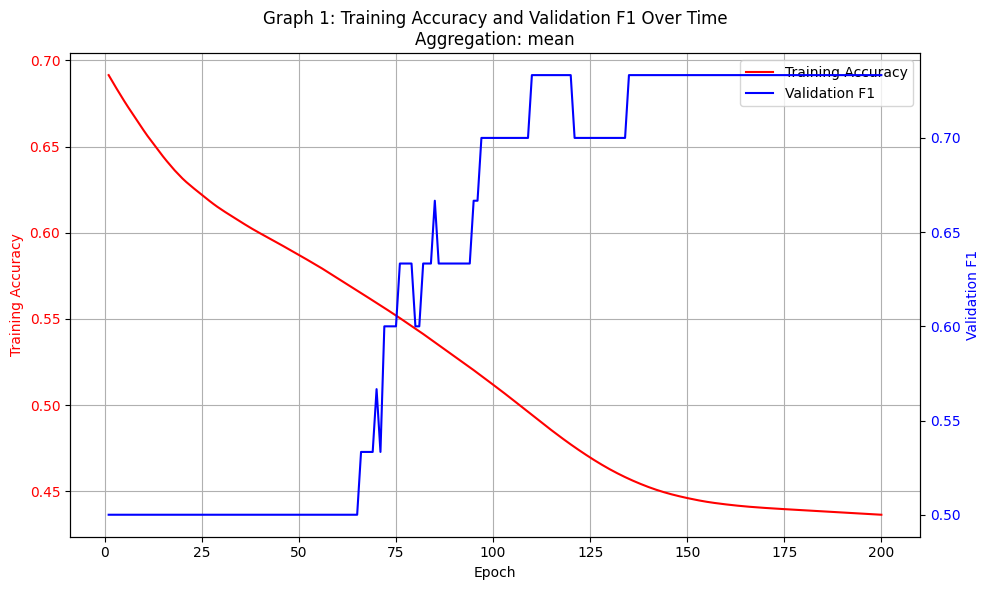

4
Selected embeddings shape: (80, 8)


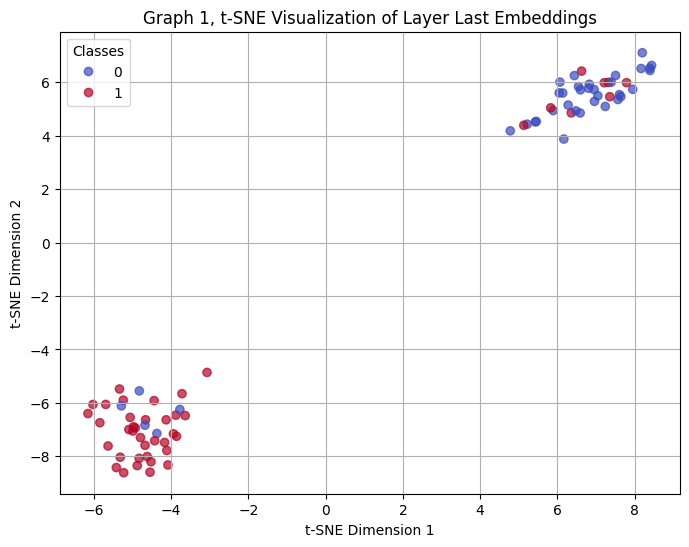

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 2, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 3, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 4, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 5, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 6, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 7, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 8, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 9, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 10, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 11, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 12, Training Loss: 48.75, Train F1: 0.5125, Validation F1: 0.3667
Epoch 13

<Figure size 1000x600 with 0 Axes>

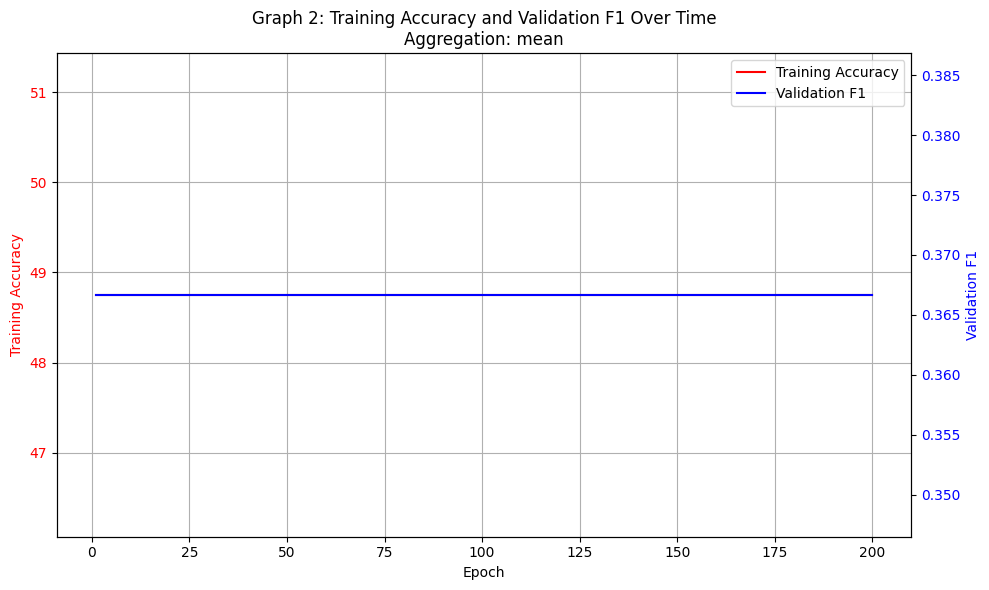

4
Selected embeddings shape: (80, 8)


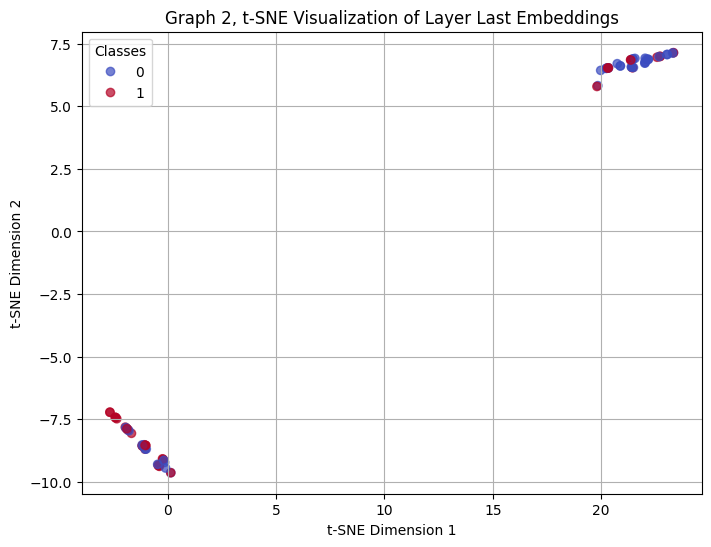

In [42]:
# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
num_layers = 4
model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)
print(model)

losses, train_f1, val_f1, last_embeddings = train_model(
    model,
    G1_train,
    G1_eval,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
    return_embeddings = True #NOTE we added this parameter
)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 1: Training Accuracy and Validation F1 Over Time")

X,A,y = G1_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Graph 1")



model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)
print(model)

losses, train_f1, val_f1, last_embeddings = train_model(
    model,
    G2_train,
    G2_eval,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
    return_embeddings = True #NOTE we added this parameter
)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 2: Training Accuracy and Validation F1 Over Time")

X,A,y = G2_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Graph 2")

### Q3.2.c - Training the Model on Merged Graphs G = G1 ∪ G

• Implement a GCN that trains on both graphs at once. Plot the training curve.

• Compare the performance of G = G1 ∪ G2 against training on G1 and G2, respectively.

• Plot TSNE plots.

In [26]:
# SOLUTION Q3.2.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

# Implement the training of G = {G1 U G2}

def train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True):

    def combine_graphs(graph1, graph2):
        X1, A1, y1 = graph1
        X2, A2, y2 = graph2
        A_combined = torch.block_diag(A1, A2)
        X_combined = torch.cat([X1, X2], dim=0)
        y_combined = torch.cat([y1, y2], dim=0)
        return X_combined, symmetric_normalize(A_combined), y_combined

    X_train, A_train, y_train = combine_graphs(G1_train, G2_train)
    X_eval, A_eval, y_eval = combine_graphs(G1_eval, G2_eval)

    G_train = (X_train, A_train, y_train)
    G_val = (X_eval, A_eval, y_eval)

    input_dim = X_train.shape[1]
    hidden_dim = 8
    num_layers = 4

    model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)
    print(model)

    losses, train_f1, val_f1, last_embeddings = train_model(
        model,
        G_train,
        G_val,
        num_epochs=num_epochs,
        lr=lr,
        verbose=verbose,
        return_embeddings = True #NOTE we added this parameter
    )

    return losses, train_f1, val_f1, G_train, last_embeddings

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Running the evaluation.

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.6980757713317871, Train F1: 0.5125, Validation F1: 0.5667
Epoch 2, Training Loss: 0.6966773271560669, Train F1: 0.5125, Validation F1: 0.5667
Epoch 3, Training Loss: 0.6952475905418396, Train F1: 0.5125, Validation F1: 0.5667
Epoch 4, Training Loss: 0.6937954425811768, Train F1: 0.5125, Validation F1: 0.5667
Epoch 5, Training Loss: 0.6923395395278931, Train F1: 0.5125, Validation F1: 0.5667
Epoch 6, Training Loss: 0.6908798217773438, Train F1: 0.5125, Validation F1: 0.5667
Epoch 7, Training Loss: 0.6894124150276184, Train F1: 0.5125, Validation F1: 0.5667
Epoch 8, Training Loss: 0.6879192590713501, Train F1: 0.5125, Validation F1: 0.5667
Epoch 9, Training Loss: 0.686407208442688, Train F1: 0.5125, Validation F1: 0.5667
Epoch 10, Training Loss: 0.6848515272140503, Train F1: 0.5125, Validation F1: 0.5667
Epoch 11, Training Loss

<Figure size 1000x600 with 0 Axes>

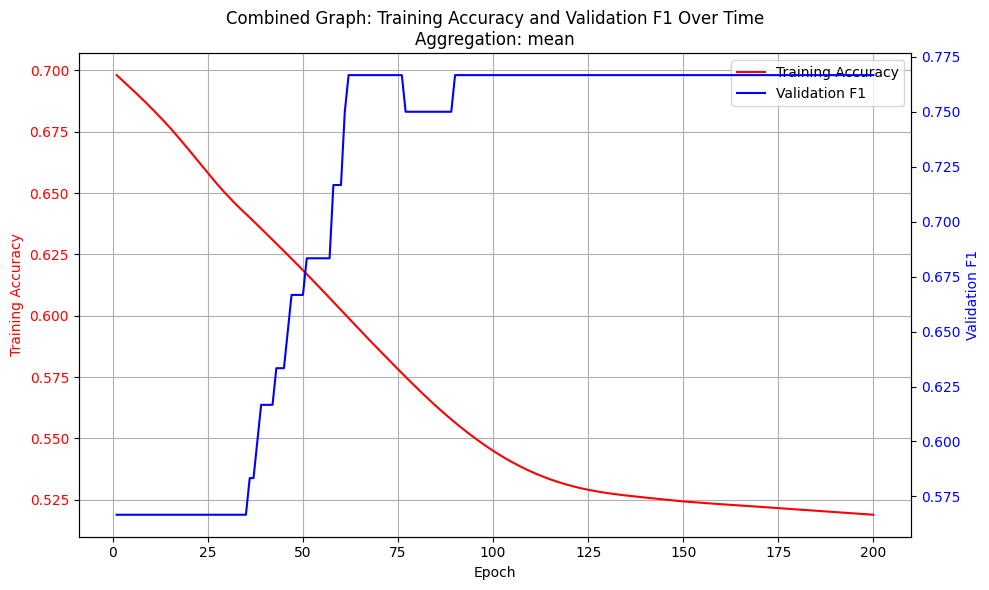

4


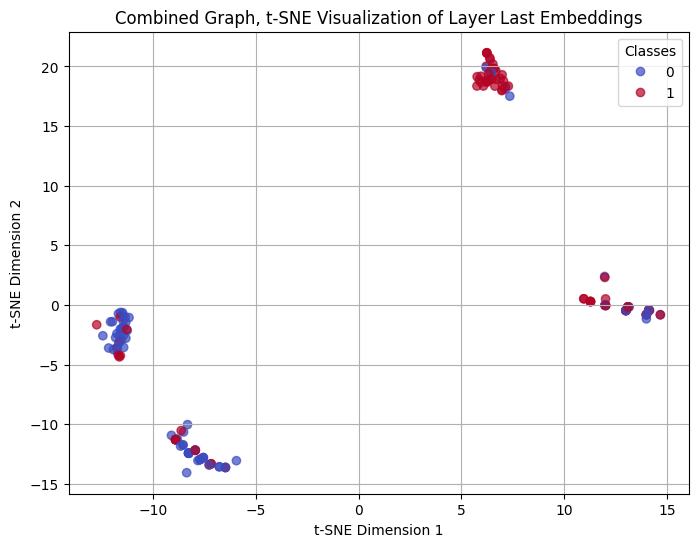

In [37]:

# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

losses, train_f1, val_f1, G_train, last_embeddings = train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Combined Graph: Training Accuracy and Validation F1 Over Time")


X,A,y = G_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Combined Graph")


### Q3.2.d Implement & discuss what you observe.

• Compare training results, embeddings, and overall observations between independent and
merged training.

• Formulate a hypothesis explaining your observations.

• Discuss different implementation options for training on both graphs, including your choice.
(e.g. what model modifications are possible; what training modifications are possible?)

• Provide relevant plots and tables where appropriate.

• Bonus: Implement a modification (or alternative approach) for training on G1 ∪ G2 and
compare outcomes.

In [ ]:
# SOLUTION Q3.2.d
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

# Implement the training of G = {G1 U G2}

# In the end return a single function:
# def train_G1UG2_v2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True):
#     """"""
#     # INSERT necessary things
#     return losses, train_f1, val_f1

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Runnning the evaluation. 

Note: It is optional to run this particular evaluation. You can modify it as needed.

In [ ]:

# Load data
# G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
# G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
# G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# losses, train_f1, val_f1 = train_G1UG2_v2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True)

# plot_training_and_validation(losses, val_f1)


## 3.3 Topological changes to improve training

### Q3.3.a - Plot the Ricci Curvature for each edge.

• Plot a barplot of the the Ricci curvature per edge, where the x-axis are the edges and y-axis
is the ricci curvature.

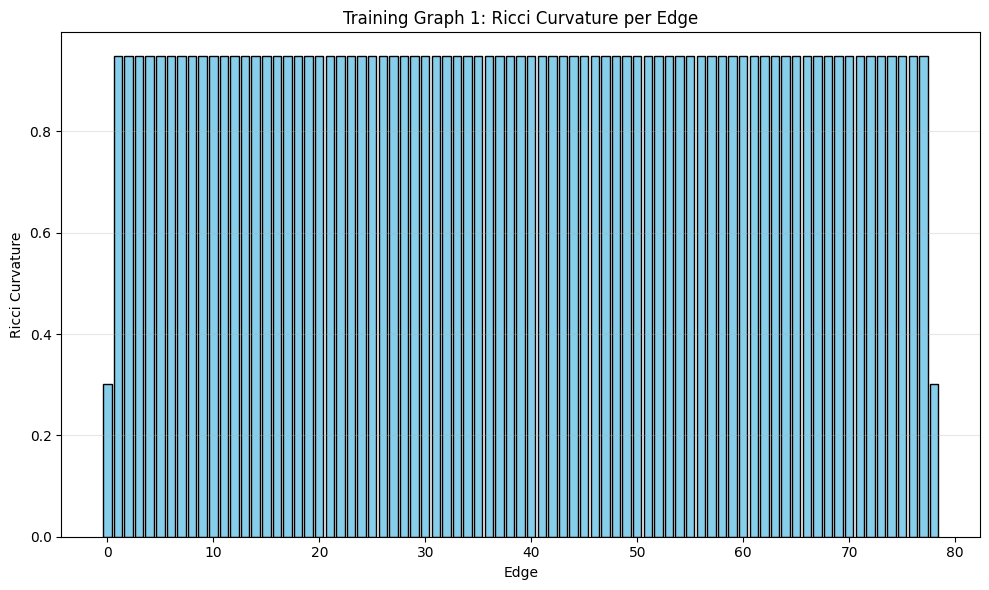

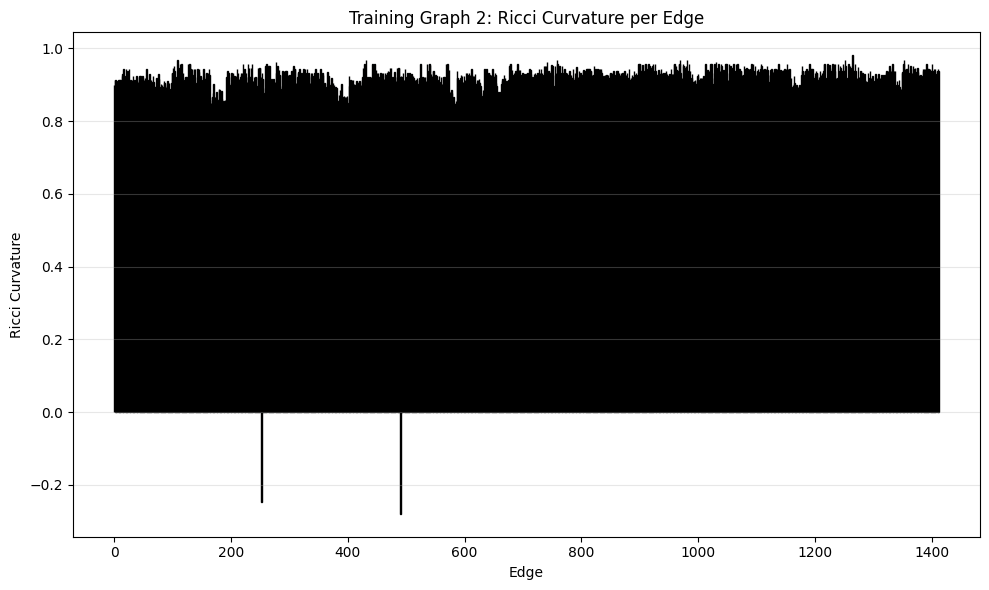

In [48]:
# SOLUTION Q3.3.a
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

from graph_ricci_curvature import GraphRicciCurvature

# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label


# Plot curvature against edges
from graph_ricci_curvature import GraphRicciCurvature 

def plot_ricci_per_edge(A, label="Graph", figsize=(10, 6)):
    """
    Plots a barplot of the Ollivier-Ricci curvature per edge for two graphs
    defined by adjacency matrices A1 and A2 (PyTorch tensors).

    Parameters
    ----------
    A1, A2 : torch.Tensor
        Adjacency matrix for undirected graph (NxN).
    """
    A_np = A.numpy
    G = nx.from_numpy_array(A.numpy())

    ricci_calculator_G = GraphRicciCurvature(G)
    curvatures_G_dict = ricci_calculator_G.compute_ricci_curvatures()

    # Retrieve curvature values per edge. Starting from Python 3.7, dictionaries preserve the insertion order as part of the language specification
    curvatures_G = list(curvatures_G_dict.values())

    plt.figure(figsize=figsize)

    plt.bar(range(len(curvatures_G)), curvatures_G, color="skyblue", edgecolor="black")
    plt.title(f"{label}: Ricci Curvature per Edge")
    plt.ylabel("Ricci Curvature")
    plt.xlabel("Edge")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


A1 = G1_train[1]  # Get adjacency matrix of first graph in G1
A2 = G2_train[1]  # Get adjacency matrix of first graph in G2

# ####################################################
# END OF MODIFICATION
# ####################################################  
# 
plot_ricci_per_edge(A1, label="Training Graph 1")
plot_ricci_per_edge(A2, label="Training Graph 2") 

### Q3.3.b Investigate the extreme case topologies.

• How would you modify a topology so that the graph structure is ignored, making the GNN
behave like an MLP?

• What would an ideal graph structure be for optimal training and testing if labels were
available (both during training and testing)?

• What are you observations? Analyze the scores and what does it mean about the dataset?

• Provide relevant plots and results.

In [63]:
# SOLUTION Q3.3.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


def augment_graph_gold_labels(G):
    """Augment graph to return A that would be 'perfect'"""
    # Connect nodes of the same class
    X, A, y = G

    num_nodes = A.shape[0]
    A_perfect = torch.zeros((num_nodes, num_nodes))

    # Connect nodes of the same class (create a complete subgraph for each class)
    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        for i in class_indices:
            for j in class_indices:
                if i != j:
                    A_perfect[i, j] = 1

    return X, A_perfect, y

def augment_graph_no_effect(G):
    """Modify graph to return A that has no 'effect'"""
    X,A,y = G
    return X,torch.eye(A.shape[0]),y


def improved_training(
        G_train,
        G_eval,
        model_params,
        num_epochs=200,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = {},
    ):
    """
    How can you improve the topologies to train better.
    """
    if change_topology_params["augmentation_strategy"] == "no_effect":
        augmentation_function = augment_graph_no_effect
    elif change_topology_params["augmentation_strategy"] == "gold":
        augmentation_function = augment_graph_gold_labels
    else:
        raise NotImplementedError("This augmentation setting is not implemented.")

    G_train = augmentation_function(G_train)
    G_train = G_train[0],symmetric_normalize(G_train[1]),G_train[2]

    G_eval = augmentation_function(G_eval)
    G_eval = G_eval[0],symmetric_normalize(G_eval[1]),G_eval[2]

    # Initialising the model
    model = LayeredGCN(**model_params)
    print(model)

    losses, train_f1, val_f1, last_embeddings = train_model(
        model,
        G_train,
        G_eval,
        num_epochs=num_epochs,
        lr=lr,
        verbose=verbose,
        return_embeddings = True
    )
    return losses, train_f1, val_f1, last_embeddings

# ####################################################
# END OF MODIFICATION
# ####################################################  


### Code to run improvement
Note: run it a few times to see what performance can be reached on the eval dataset.

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.7037886381149292, Train F1: 0.4625, Validation F1: 0.5000
Epoch 2, Training Loss: 0.7031651735305786, Train F1: 0.4625, Validation F1: 0.5000
Epoch 3, Training Loss: 0.7025479078292847, Train F1: 0.4625, Validation F1: 0.5000
Epoch 4, Training Loss: 0.7019425630569458, Train F1: 0.4625, Validation F1: 0.5000
Epoch 5, Training Loss: 0.7013348340988159, Train F1: 0.4625, Validation F1: 0.5000
Epoch 6, Training Loss: 0.7007405161857605, Train F1: 0.4625, Validation F1: 0.5000
Epoch 7, Training Loss: 0.7001626491546631, Train F1: 0.4625, Validation F1: 0.5000
Epoch 8, Training Loss: 0.6995883584022522, Train F1: 0.4625, Validation F1: 0.5000
Epoch 9, Training Loss: 0.6990278959274292, Train F1: 0.4625, Validation F1: 0.5000
Epoch 10, Training Loss: 0.6984810829162598, Train F1: 0.4625, Validation F1: 0.5000
Epoch 11, Training Los

<Figure size 1000x600 with 0 Axes>

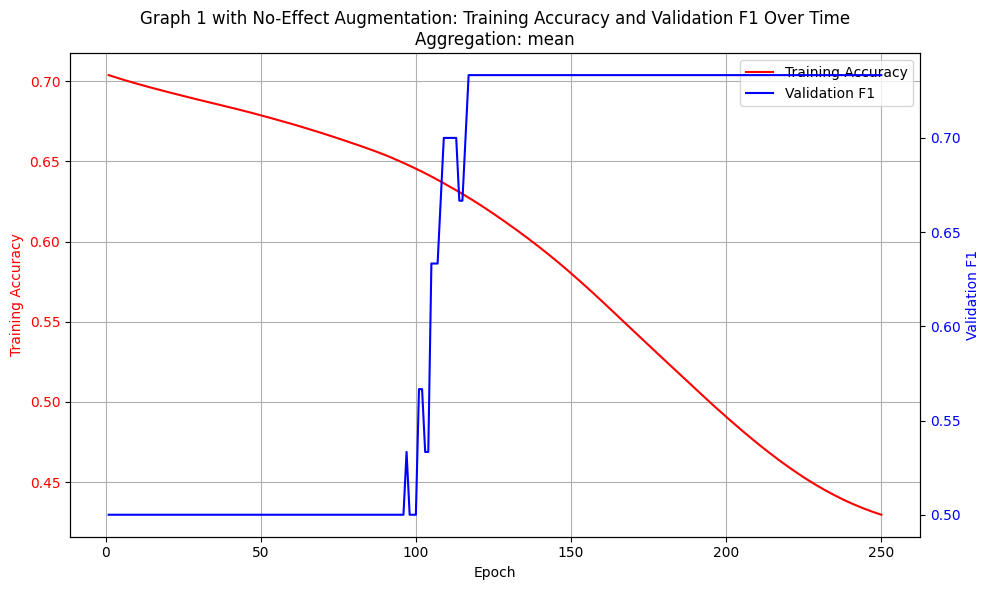

4
Selected embeddings shape: (80, 8)


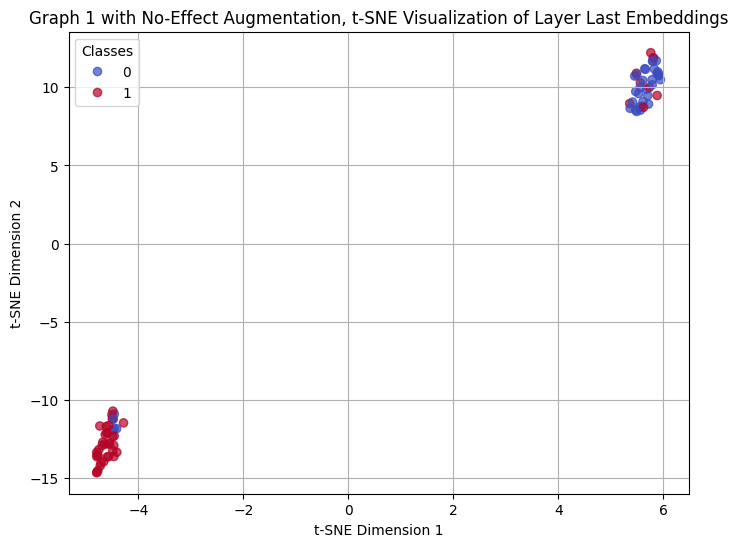

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.6905384063720703, Train F1: 0.5375, Validation F1: 0.5000
Epoch 2, Training Loss: 0.6898496150970459, Train F1: 0.5375, Validation F1: 0.5000
Epoch 3, Training Loss: 0.689161479473114, Train F1: 0.5375, Validation F1: 0.5000
Epoch 4, Training Loss: 0.6884734630584717, Train F1: 0.5375, Validation F1: 0.5000
Epoch 5, Training Loss: 0.6877850890159607, Train F1: 0.5375, Validation F1: 0.5000
Epoch 6, Training Loss: 0.687164843082428, Train F1: 0.5375, Validation F1: 0.5000
Epoch 7, Training Loss: 0.6865904331207275, Train F1: 0.5375, Validation F1: 0.5000
Epoch 8, Training Loss: 0.6859563589096069, Train F1: 0.5375, Validation F1: 0.5000
Epoch 9, Training Loss: 0.6853342056274414, Train F1: 0.5375, Validation F1: 0.5000
Epoch 10, Training Loss: 0.6847542524337769, Train F1: 0.5375, Validation F1: 0.5000
Epoch 11, Training Loss:

<Figure size 1000x600 with 0 Axes>

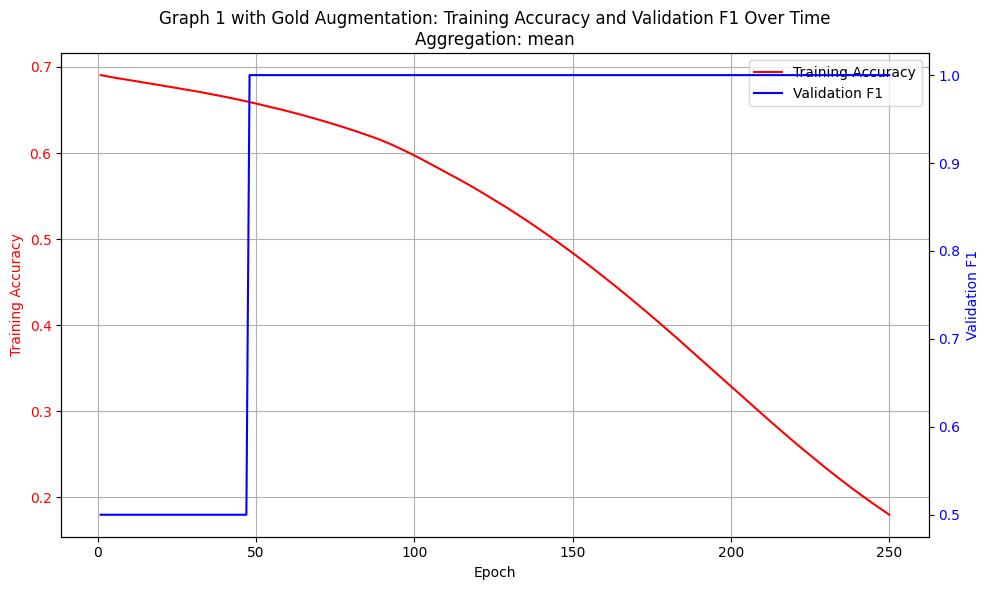

4
Selected embeddings shape: (80, 8)


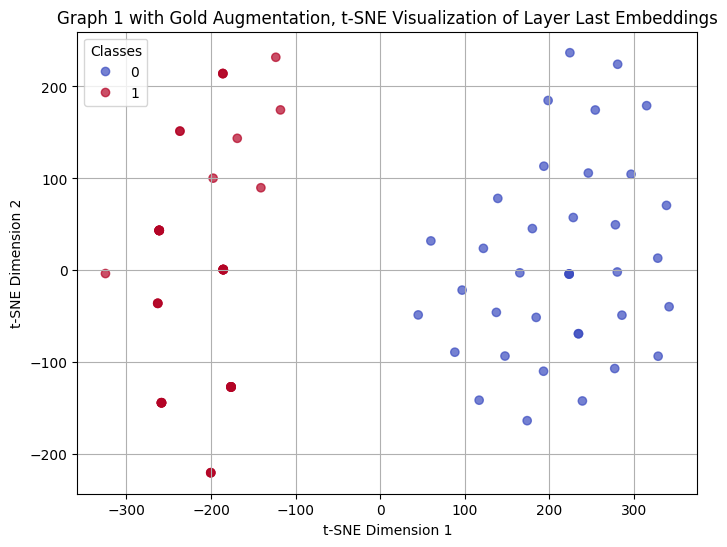

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.6964830160140991, Train F1: 0.4875, Validation F1: 0.6333
Epoch 2, Training Loss: 0.6963785886764526, Train F1: 0.4875, Validation F1: 0.6333
Epoch 3, Training Loss: 0.6962718367576599, Train F1: 0.4875, Validation F1: 0.6333
Epoch 4, Training Loss: 0.6961675882339478, Train F1: 0.4875, Validation F1: 0.6333
Epoch 5, Training Loss: 0.6960680484771729, Train F1: 0.4875, Validation F1: 0.6333
Epoch 6, Training Loss: 0.6959617137908936, Train F1: 0.4875, Validation F1: 0.6333
Epoch 7, Training Loss: 0.6958580613136292, Train F1: 0.4875, Validation F1: 0.6333
Epoch 8, Training Loss: 0.6957629919052124, Train F1: 0.4875, Validation F1: 0.6333
Epoch 9, Training Loss: 0.6956827044487, Train F1: 0.4875, Validation F1: 0.6333
Epoch 10, Training Loss: 0.6955963373184204, Train F1: 0.4875, Validation F1: 0.6333
Epoch 11, Training Loss: 

<Figure size 1000x600 with 0 Axes>

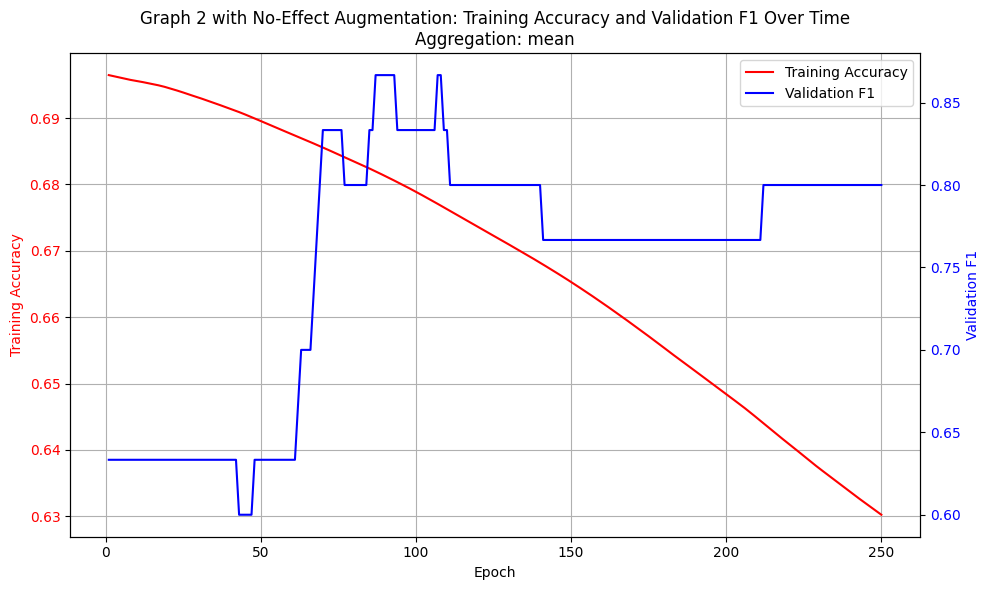

4
Selected embeddings shape: (80, 8)


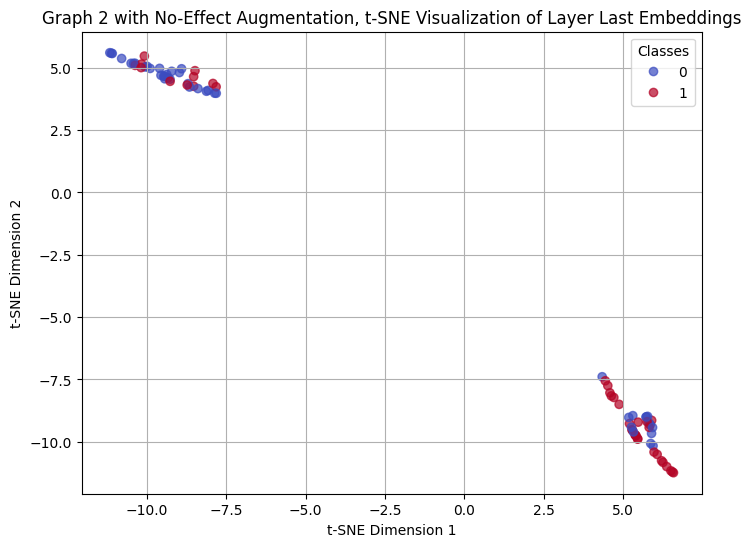

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.7063709497451782, Train F1: 0.4875, Validation F1: 0.6333
Epoch 2, Training Loss: 0.7062435150146484, Train F1: 0.4875, Validation F1: 0.6333
Epoch 3, Training Loss: 0.7061175107955933, Train F1: 0.4875, Validation F1: 0.6333
Epoch 4, Training Loss: 0.7059931755065918, Train F1: 0.4875, Validation F1: 0.6333
Epoch 5, Training Loss: 0.7058703899383545, Train F1: 0.4875, Validation F1: 0.6333
Epoch 6, Training Loss: 0.7057510018348694, Train F1: 0.4875, Validation F1: 0.6333
Epoch 7, Training Loss: 0.7056609988212585, Train F1: 0.4875, Validation F1: 0.6333
Epoch 8, Training Loss: 0.705564022064209, Train F1: 0.4875, Validation F1: 0.6333
Epoch 9, Training Loss: 0.7054627537727356, Train F1: 0.4875, Validation F1: 0.6333
Epoch 10, Training Loss: 0.7053591012954712, Train F1: 0.4875, Validation F1: 0.6333
Epoch 11, Training Loss

<Figure size 1000x600 with 0 Axes>

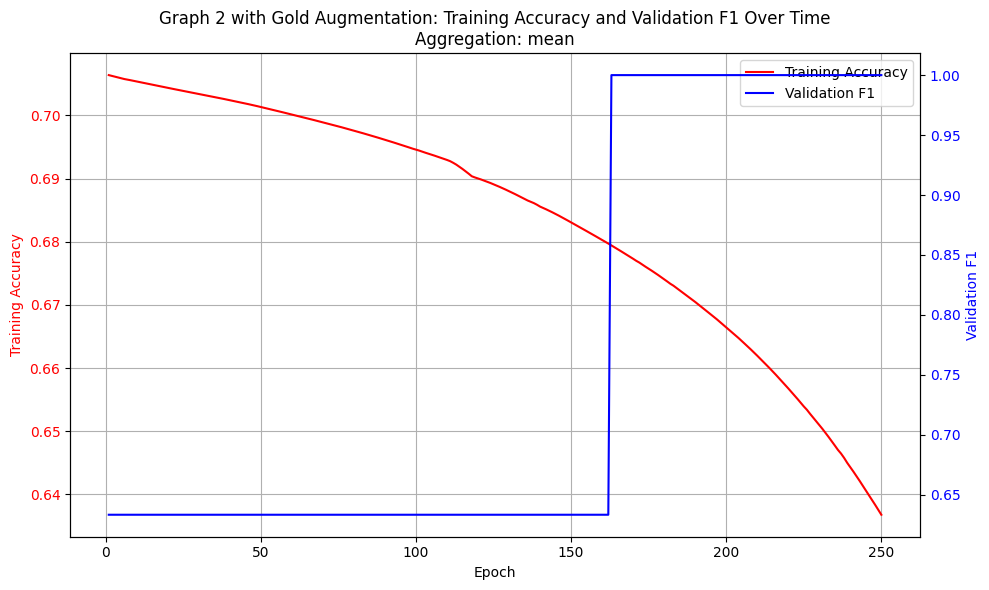

4
Selected embeddings shape: (80, 8)


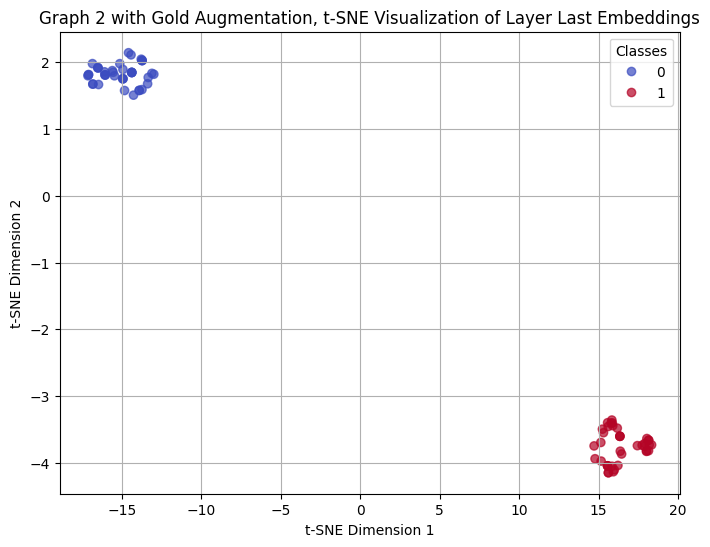

In [68]:
# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

model_params = {    
    "input_dim":10, 
    "hidden_dim":8,
    "num_layers":4,
}

change_topology_params_no_augment = {
    "augmentation_strategy":"no_effect",
    "normalise" : False,
}

change_topology_params_gold = {
    "augmentation_strategy":"gold",
    "normalise" : True,
}

# Graph 1

losses, train_f1, val_f1, last_embeddings = improved_training(
    G1_train,
    G1_eval,
    model_params=model_params,
    num_epochs=250,
    lr=0.0005,
    verbose=True,
    return_embeddings = True,
    change_topology_params = change_topology_params_no_augment
)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 1 with No-Effect Augmentation: Training Accuracy and Validation F1 Over Time")


X,A,y = G1_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Graph 1 with No-Effect Augmentation")


losses, train_f1, val_f1, last_embeddings = improved_training(
    G1_train,
    G1_eval,
    model_params=model_params,
    num_epochs=250,
    lr=0.0005,
    verbose=True,
    return_embeddings = True,
    change_topology_params = change_topology_params_gold
)
plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 1 with Gold Augmentation: Training Accuracy and Validation F1 Over Time")

X,A,y = G1_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Graph 1 with Gold Augmentation")


# Graph 2

losses, train_f1, val_f1, last_embeddings = improved_training(
    G2_train,
    G2_eval,
    model_params=model_params,
    num_epochs=250,
    lr=0.0005,
    verbose=True,
    return_embeddings = True,
    change_topology_params = change_topology_params_no_augment
)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 2 with No-Effect Augmentation: Training Accuracy and Validation F1 Over Time")

X,A,y = G2_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Graph 2 with No-Effect Augmentation")


losses, train_f1, val_f1, last_embeddings = improved_training(
    G2_train,
    G2_eval,
    model_params=model_params,
    num_epochs=250,
    lr=0.0005,
    verbose=True,
    return_embeddings = True,
    change_topology_params = change_topology_params_gold
)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 2 with Gold Augmentation: Training Accuracy and Validation F1 Over Time")

X,A,y = G2_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Graph 2 with Gold Augmentation")

### Q3.3.C Improving Graph Topology for Better Learning

• Implement two graph modifications.

• Describe your modifications.

• What motivated your implementation?

• If it helped give a hypothesis on why you think that is? If it did not give a hypothesis why
you think it did not help.

• Provide relevant plots and results

In [70]:
# SOLUTION Q3.3.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def edge_dropout(A, drop_prob=0.05):
    """
    Randomly removes edges from the adjacency matrix A with a given probability.
    """
    A_upper = torch.triu(A, diagonal=1)  # Upper triangular to avoid duplicate removals in undirected graphs
    mask = (torch.rand_like(A_upper) > drop_prob).float()
    A_upper_dropped = A_upper * mask
    A_symmetric = A_upper_dropped + A_upper_dropped.T  # Symmetrize adjacency
    return A_symmetric

def add_similar_edges(X, A, top_k=2):
    """
    Adds edges between top-k most similar nodes based on cosine similarity of node features.
    """

    X_norm = F.normalize(X, p=2, dim=1)  # Normalize each feature vector
    sim_matrix = torch.mm(X_norm, X_norm.T) 

    sim_matrix.fill_diagonal_(0)  # Ignore self-similarity

    # Add top-k edges for each node
    for node in range(sim_matrix.shape[0]):
        top_k_nodes = torch.topk(sim_matrix[node], top_k).indices
        for neighbor in top_k_nodes:
            A[node, neighbor] = 1
            A[neighbor, node] = 1  # Ensure symmetry
    return A


def augment_graph_edge_dropout_add_similar_edges(G, drop_prob=0.05, top_k=2):
    """
    Applies graph augmentation: edge dropout + edge addition based on feature similarity.
    """
    X, A, y = G

    # Edge dropout
    A_aug = edge_dropout(A, drop_prob=drop_prob)

    # Edge addition based on top-k similar nodes
    A_aug = add_similar_edges(X, A_aug, top_k=top_k)

    return X, A_aug, y

def improved_training(
        G_train,
        G_eval,
        model_params,
        num_epochs=200,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = {},
    ):
    """
    How can you improve the topologies to train better.
    """

    if change_topology_params["augmentation_strategy"] == "eval":
        augmentation_function = augment_graph_edge_dropout_add_similar_edges
    else:
        raise NotImplementedError("This augmentation setting is not implemented.")


    G_train = augmentation_function(G_train)
    G_train = G_train[0],symmetric_normalize(G_train[1]),G_train[2]

    G_eval = augmentation_function(G_eval)
    G_eval = G_eval[0],symmetric_normalize(G_eval[1]),G_eval[2]

    # Initialising the model
    model = LayeredGCN(**model_params)
    print(model)

    losses, train_f1, val_f1, last_embeddings = train_model(
        model,
        G_train,
        G_eval,
        num_epochs=num_epochs,
        lr=lr,
        verbose=verbose,
        return_embeddings = True
    )
    return losses, train_f1, val_f1, last_embeddings

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Code to run improvement

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.720059871673584, Train F1: 0.4625, Validation F1: 0.5000
Epoch 2, Training Loss: 0.7194157242774963, Train F1: 0.4625, Validation F1: 0.5000
Epoch 3, Training Loss: 0.7187754511833191, Train F1: 0.4625, Validation F1: 0.5000
Epoch 4, Training Loss: 0.7181417942047119, Train F1: 0.4625, Validation F1: 0.5000
Epoch 5, Training Loss: 0.7175155878067017, Train F1: 0.4625, Validation F1: 0.5000
Epoch 6, Training Loss: 0.7168979644775391, Train F1: 0.4625, Validation F1: 0.5000
Epoch 7, Training Loss: 0.7162947654724121, Train F1: 0.4625, Validation F1: 0.5000
Epoch 8, Training Loss: 0.7157022356987, Train F1: 0.4625, Validation F1: 0.5000
Epoch 9, Training Loss: 0.715114951133728, Train F1: 0.4625, Validation F1: 0.5000
Epoch 10, Training Loss: 0.7145382761955261, Train F1: 0.4625, Validation F1: 0.5000
Epoch 11, Training Loss: 0.

<Figure size 1000x600 with 0 Axes>

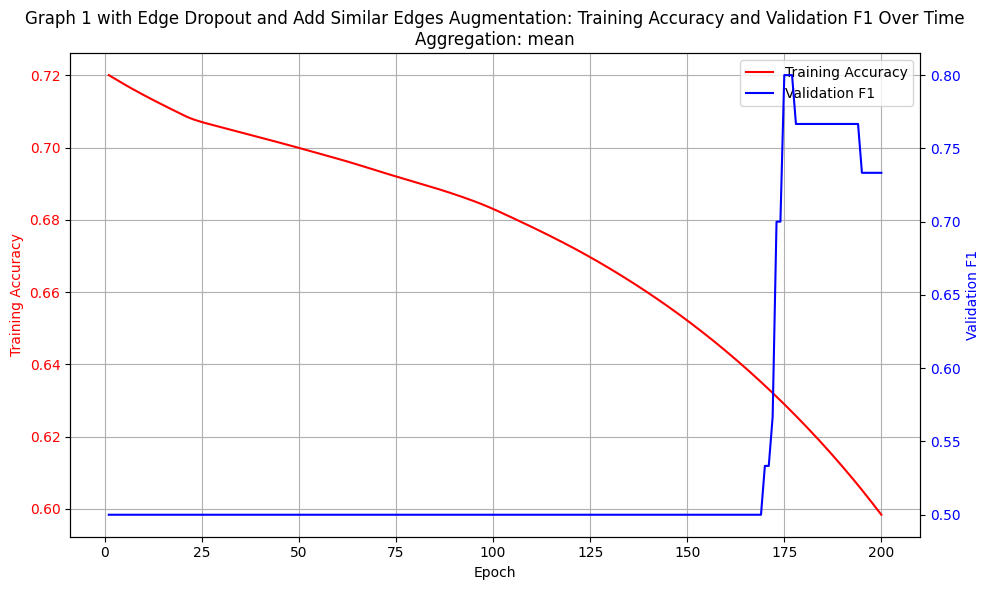

4
Selected embeddings shape: (80, 8)


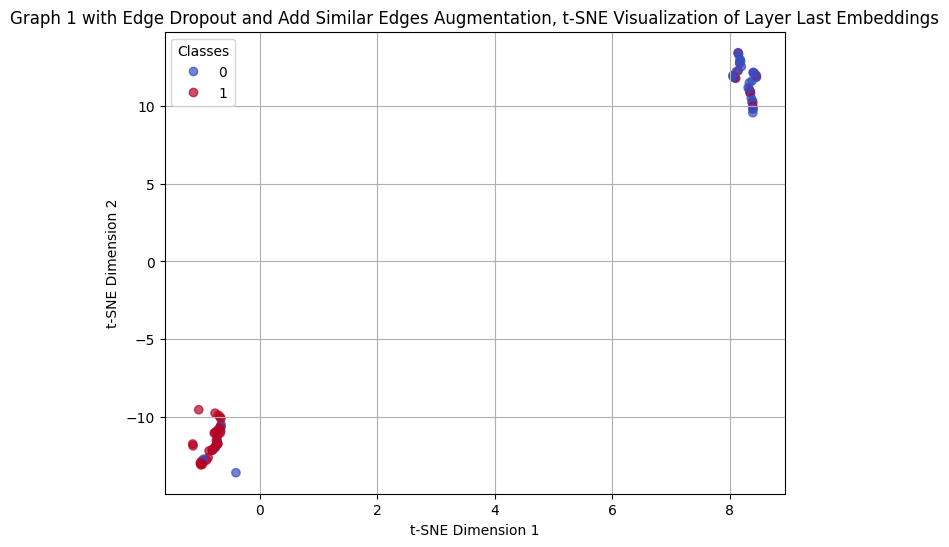

LayeredGCN(
  (gcn_layers): ModuleList(
    (0-3): 4 x GCNLayer()
  )
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.6897144913673401, Train F1: 0.5125, Validation F1: 0.3667
Epoch 2, Training Loss: 0.6895350217819214, Train F1: 0.5125, Validation F1: 0.3667
Epoch 3, Training Loss: 0.6893558502197266, Train F1: 0.5125, Validation F1: 0.3667
Epoch 4, Training Loss: 0.6891772150993347, Train F1: 0.5125, Validation F1: 0.3667
Epoch 5, Training Loss: 0.6889994144439697, Train F1: 0.5125, Validation F1: 0.3667
Epoch 6, Training Loss: 0.688826322555542, Train F1: 0.5125, Validation F1: 0.3667
Epoch 7, Training Loss: 0.6886546015739441, Train F1: 0.5125, Validation F1: 0.3667
Epoch 8, Training Loss: 0.6884816884994507, Train F1: 0.5125, Validation F1: 0.3667
Epoch 9, Training Loss: 0.6883077025413513, Train F1: 0.5125, Validation F1: 0.3667
Epoch 10, Training Loss: 0.6881330609321594, Train F1: 0.5125, Validation F1: 0.3667
Epoch 11, Training Loss

<Figure size 1000x600 with 0 Axes>

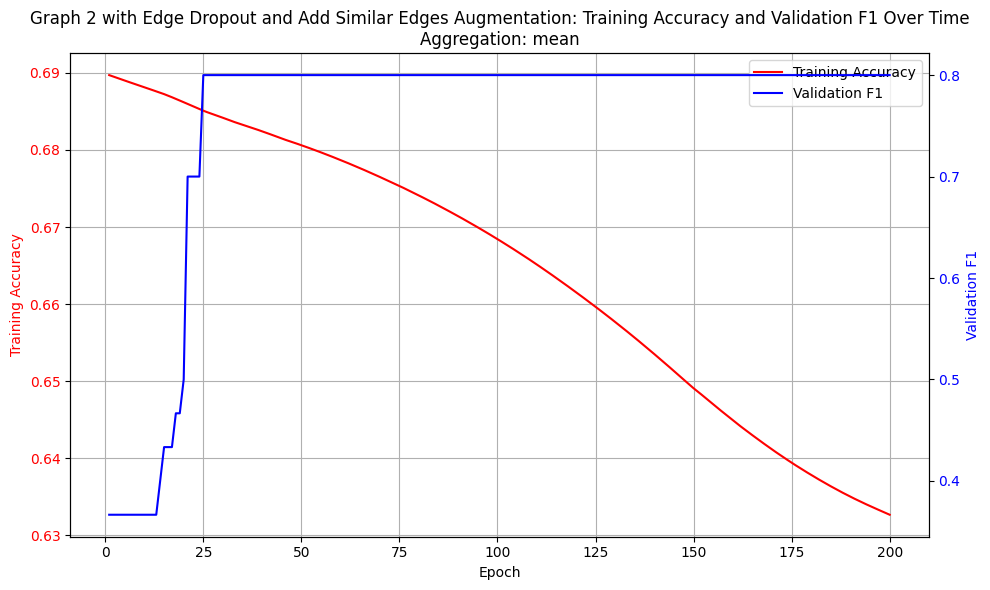

4
Selected embeddings shape: (80, 8)


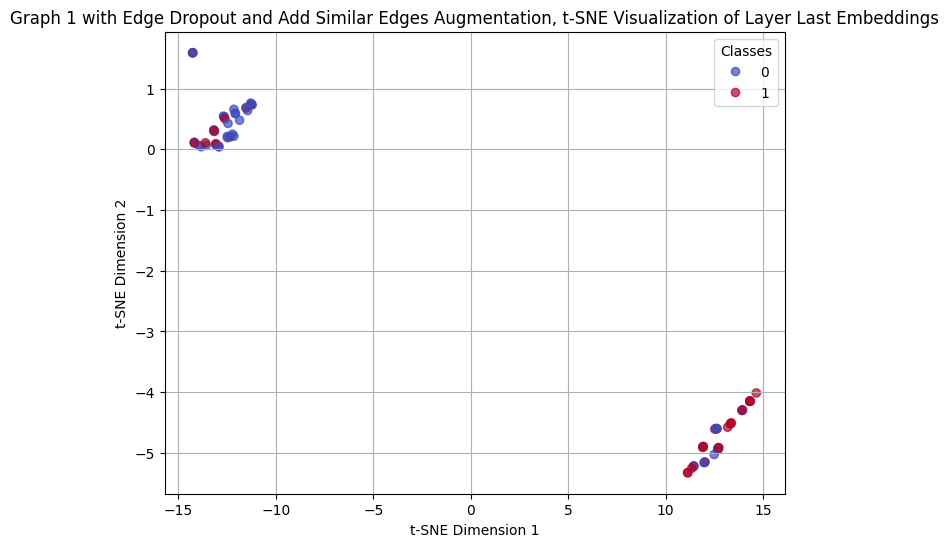

In [74]:
# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label


model_params = {    
    "input_dim":10, 
    "hidden_dim":8,
    "num_layers":4,
}

change_topology_params_eval = {
    "augmentation_strategy":"eval",
}

# Graph 1

losses, train_f1, val_f1, last_embeddings = improved_training(
    G1_train,
    G1_eval,
    model_params=model_params,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
    return_embeddings = True,
    change_topology_params = change_topology_params_eval
)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 1 with Edge Dropout and Add Similar Edges Augmentation: Training Accuracy and Validation F1 Over Time")

X,A,y = G1_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Graph 1 with Edge Dropout and Add Similar Edges Augmentation")

# Graph 2

losses, train_f1, val_f1, last_embeddings = improved_training(
    G2_train,
    G2_eval,
    model_params=model_params,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
    return_embeddings = True,
    change_topology_params = change_topology_params_eval
)

plot_training_and_validation(losses,
                             val_f1,
                             graph1_label  = "Training Accuracy",
                             graph2_label = "Validation F1",
                             title="Graph 2 with Edge Dropout and Add Similar Edges Augmentation: Training Accuracy and Validation F1 Over Time")

X,A,y = G2_train
print(len(last_embeddings))
plot_tsne(last_embeddings, y, graph_name="Graph 1 with Edge Dropout and Add Similar Edges Augmentation")